TP5: Le but du TP est d’étudier le chemin de régularisation du Lasso.

1. Reprendre les données ’prostate’ du premier TP les centrer et les réduire

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
url_data = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(url_data, delimiter='\t')
variables = df.columns[1:9]
df[variables] = df[variables].apply(lambda x: (x - x.mean()) / x.std())
# Get the training and test sets
Y_train = df.loc[df["train"]=="T", 'lpsa'].to_numpy()
X_train = df.loc[df["train"]=="T", variables].to_numpy()
print("Training set : n = {} samples and p = {} dimensions".format(X_train.shape[0],
X_train.shape[1]))
Y_test = df.loc[df["train"]=="F", 'lpsa'].to_numpy()
X_test = df.loc[df["train"]=="F", variables].to_numpy()
print("Test set : n = {} samples and p = {} dimensions".format(X_test.shape[0], X_test.
shape[1]))
Xn = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
n, p = Xn.shape
yn = (Y_train - Y_train.mean())/Y_train.std()

Training set : n = 67 samples and p = 8 dimensions
Test set : n = 30 samples and p = 8 dimensions


2. les conditions d’optimalités du Lasso

a) Résoudre le problème du Lasso sous la forme

In [69]:
import cvxpy as cvx
lamda = 23.38
b = cvx.Variable(p)
obj = cvx.Minimize(cvx.sum_squares(Xn@b - yn) + lamda*cvx.norm(b, 1))
prob = cvx.Problem(obj)
prob.solve(solver=cvx.SCS, eps=1e-5)

print("solutio Lasso :", b.value)
print("coefficients non nuls :", np.abs(b.value) > 1e-5)

solutio Lasso : [ 0.465  0.156 -0.000  0.002  0.079 -0.000 -0.000 -0.000]
coefficients non nuls : [ True  True False  True  True False False False]


b) démontrez numériquement que cette solution est bien optimale

In [81]:
b_hat = b.value
grad = 2 * Xn.T @ (Xn @ b_hat - yn)
for j in range(p):
    if abs(b_hat[j]) > 1e-5:
        print(f"j={j}: g({b_hat[j]}) lamda * {np.sign(b_hat[j])} =", grad[j] + lamda * np.sign(b_hat[j]))
    else:
        print(f"j={j}:", abs(grad[j]), "<=", lamda)

j=0: g(0.5931444842602372) lamda * 1.0 = 23.380000000000095
j=1: g(0.24229135512063343) lamda * 1.0 = 23.38000000000004
j=2: g(-0.11802302729236946) lamda * -1.0 = -23.379999999999995
j=3: g(0.17553030474789705) lamda * 1.0 = 23.38000000000001
j=4: g(0.2563474603941618) lamda * 1.0 = 23.38000000000004
j=5: g(-0.23928030279060755) lamda * -1.0 = -23.37999999999994
j=6: g(-0.01731521148277503) lamda * -1.0 = -23.37999999999997
j=7: g(0.22962676117415126) lamda * 1.0 = 23.38000000000002


In [80]:
print(max(grad / np.sign(b.value)))

15.576785771030359


La solution du lasso selectionne autpmatiquement 4 variables dont les coefficients sont non nuls. Pour les variables actifs la condition de stationnarité gradient en j + lamda * sign (beta j) est sensiblement egal a zero a 10**-5 pres, ce qui valide l'optimalité numérique.
Pour les coefficients non nuls, la condition de stationnarité gradient en j <= lamda est également respectée, ce qui montre que la solution satisfait bien les conditions. Donc la solution obtenue par cvxpy est optimale pour le problème du Lasso.

c)Le lasso simplifié : le lasso positif. 

In [ ]:
t = np.sum(b.value)
bc = cvx.Variable(p)
obj = cvx.Minimize(cvx.sum_squares(Xn@bc - yn))
c = [cvx.sum(bc) <= t, bc >= 0]
prob = cvx.Problem(obj, c)
prob.solve(solver=cvx.SCS, eps=1e-5)

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(f"Estimation: {bc.value}")
print("coefficients non nuls :", np.abs(bc.value) > 1e-5)
print(f"Lagrange multiplier lam = {c[0].dual_value}")
print(c[1].dual_value)

indzero = np.where(bc.value <= 1e-5)
print("indices nuls :", bc.value[indzero])
nonzero = np.where(bc.value > 1e-5)
print("indices non nuls :", bc.value[nonzero])

Estimation: [ 0.483  0.214 -0.000  0.146  0.186  0.000 -0.000  0.092]
coefficients non nuls : [ True  True False  True  True False False  True]
Lagrange multiplier lam = 2.845543665109981
[ 0.000  0.000  12.239  0.000  0.000  9.820  2.911  0.000]
indices nuls : [-0.000  0.000 -0.000]
indices non nuls : [ 0.483  0.214  0.146  0.186  0.092]


3. Le plus grand λ

a. En reprenant la formulation (1), à partir de la solution des moindres carrés et en
utilisant les conditions d’optimalités, calculer le plus petit λ tel que tous les tous les
coefficients soient nul. Pourquoi peut-on qualifier cette valeur de "plus grand λ" ?<br>
b. Quelle va être la première composante du vecteur de β non nulle à être activée

In [111]:
lam = np.max(np.abs(2 * Xn.T @ yn)) - 1
print("lambda max :", lam)
b1 = cvx.Variable(p)
obj = cvx.Minimize(cvx.sum_squares(Xn@b1 - yn) + lam*cvx.norm(b1, 1))
prob = cvx.Problem(obj)
prob.solve(solver=cvx.SCS, eps=1e-5)

b_lasso = b1.value
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(f"Estimation: {b_lasso}") # en diminuant lambda, la variable qui passe de I0 à I1 est la plus significative

lambda max : 97.24278965072583
Estimation: [ 0.007  0.000  0.000  0.000  0.000  0.000  0.000  0.000]


4. Le plus petit λ

a) Toujours avec la la formulation (1), calculer le plus grand λ tel que tous les tous les
coefficients soient non nul.<br>
b) Quelle va être a première variable à être déclarée "non pertinente" ?

In [ ]:
beta_moindres_carre = np.linalg.solve(Xn.T @ Xn, Xn.T @ yn)
v = np.linalg.solve(Xn.T@Xn, np.sign(beta_moindres_carre))
print(f"V = {v}")
beta_epsi= (beta_moindres_carre / v)
print(f"vecteur_epsi = {beta_epsi}")
epsilon = np.min(np.abs(beta_moindres_carre / v))
print(f"Epsilon = {epsilon}")

V = [ 0.051  0.005 -0.026  0.017  0.028 -0.098 -0.063  0.097]
vecteur_epsi = [ 11.595  49.010  4.460  10.099  9.162  2.446  0.275  2.377]
Epsilon = 0.2754826798615987


In [128]:
lam = epsilon
print(lam)
b1 = cvx.Variable(p)
obj = cvx.Minimize(cvx.sum_squares(Xn@b1 - yn) + lam*cvx.norm(b1, 1))
prob = cvx.Problem(obj)
prob.solve(solver=cvx.SCS, eps=1e-5)

b_lasso = b1.value
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(f"Estimation: {b_lasso}") # en diminuant lambda, la variable qui passe de I0 à I1 est la plus significative

0.2754826798615987
Estimation: [ 0.586  0.242 -0.114  0.173  0.252 -0.226 -0.009  0.216]


5. Calculez et représentez graphiquement en utilisant matplotlib la totalité du chemin de régularisation en utilisant SKlearn. Vérifiez que les résultats que vous avez sont bien conformes à ceux calculées aux question précédentes.



In [137]:
from sklearn.linear_model import lars_path
alphas, active, coefs = lars_path(Xn, yn, method='lasso')
print(f"Nombre d'alphas : {len(alphas)}")
print(f"Alphas : {alphas}")
print(f"Taille des coefs : {coefs.shape}")
print(f"actives : {active}")

Nombre d'alphas : 9
Alphas : [ 0.733  0.379  0.300  0.176  0.173  0.050  0.038  0.004  0.000]
Taille des coefs : (8, 9)
actives : [np.int64(0), np.int64(1), np.int64(4), np.int64(3), np.int64(7), np.int64(2), np.int64(5), np.int64(6)]


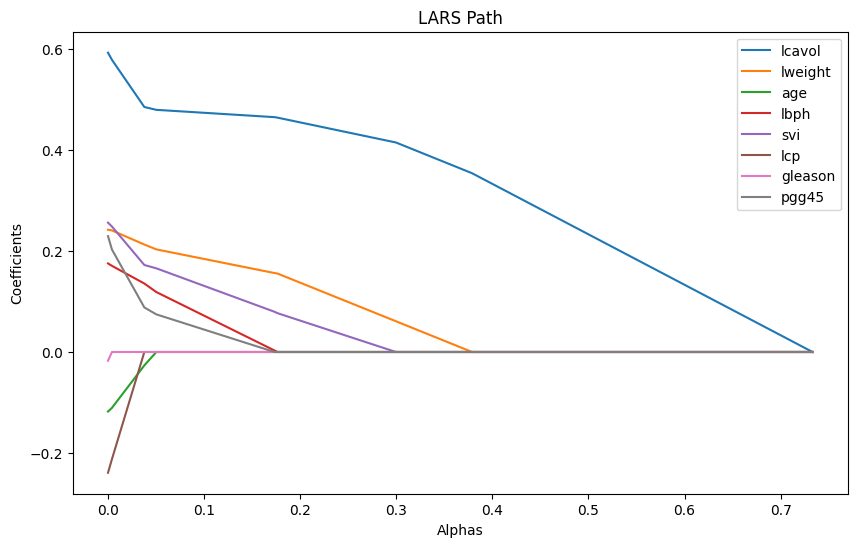

In [138]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[0]):
    plt.plot(alphas, coefs[i, :], label=variables[i])
plt.xlabel("Alphas")
plt.ylabel("Coefficients")
plt.title("LARS Path")
plt.legend()
plt.show()